In [161]:
# Francisco Dominguez Mateos
# 29/08/2021
# Voice Stress detection
# Dimension reduction with Deep Metric Learning

In [162]:
import glob
import time
import numpy as np
#np.set_printoptions(precision=3)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [163]:
import matplotlib.pyplot as plt

In [164]:
path_base="/home/francisco/datasets/datasets/sound/voice/stress"

In [165]:
def getLabel(s):
    if s=="TRUE":
        return 1.0
    if s=="FALSE":
        return 0.0
    if s=="PC":
        return 2.0
def isRightLabel(s):
    if s=="TRUE":
        return True
    if s=="FALSE":
        return True
    if s=="PC":
        return False
    return False

In [166]:
data=[]
labels=[]
file_txt=path_base+"/*.csv"
for filepath in glob.glob(file_txt):
    print("Processing file: {}".format(filepath)) 
    with open(filepath) as fp:  
        line = fp.readline()
        head_list=line.split(";")
        #for i,head in enumerate(head_list):
        #    print(i,head)
        cnt = 1
        line = fp.readline()
        while line:
            data_row=[]
            line_list=line.split(";")
            #print("Line {}: {} {} {}".format(cnt, line_list[0], line_list[1], line_list[2]))
            line = fp.readline()
            cnt += 1
            if not isRightLabel(line_list[0]):
                continue
            for i,datum in enumerate(line_list):
                #print(i,head_list[i],"=",datum)
                if i>1:
                    data_row.append(float(datum))
                if i==0:
                    labels.append(getLabel(datum))
            data.append(data_row)
data_np=np.array(data)
labels_np=np.array(labels)
print(data_np.shape)
print(data_np)
print(labels_np.shape)
print(labels_np)

Processing file: /home/francisco/datasets/datasets/sound/voice/stress/Set_Males.csv
Processing file: /home/francisco/datasets/datasets/sound/voice/stress/Set_Females.csv
(50, 68)
[[126.278 0.014 0.029 ... 15.681 0.870 0.012]
 [142.901 0.005 0.019 ... 10.834 0.936 0.008]
 [117.189 0.005 0.014 ... 11.765 0.967 0.006]
 ...
 [192.269 0.008 0.022 ... 10.600 0.928 0.007]
 [167.700 0.005 0.025 ... 9.564 0.933 0.009]
 [206.086 0.007 0.013 ... 9.851 0.922 0.046]]
(50,)
[1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 1.000 1.000 1.000
 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000]


In [167]:
from sklearn.preprocessing import StandardScaler

In [168]:
ss=StandardScaler()
data_ss=ss.fit_transform(data_np)

print(data_ss.shape)
print(data_ss)

(50, 68)
[[-0.692 1.335 0.942 ... 1.056 -1.550 -0.524]
 [-0.309 -0.907 -0.100 ... -0.261 0.011 -0.808]
 [-0.901 -0.907 -0.621 ... -0.008 0.744 -0.950]
 ...
 [0.826 -0.159 0.213 ... -0.325 -0.178 -0.879]
 [0.261 -0.907 0.525 ... -0.606 -0.060 -0.737]
 [1.144 -0.409 -0.725 ... -0.528 -0.320 1.895]]


In [169]:
def buildDataPairs(data_ss,labels_np):
    data_pairs=[]
    data_pair_labels=[]
    N=data_ss.shape[0]
    for i in range(N):
        for j in range(i+1,N):
            data_pairs.append((data_ss[i],data_ss[j]))
            label=labels_np[i]==labels_np[j]
            data_pair_labels.append(label)
    data_pairs_np=np.array(data_pairs)
    data_pair_labels_np=np.array(data_pair_labels)
    return data_pairs_np, data_pair_labels_np
data_pairs_np, data_pair_labels_np=buildDataPairs(data_ss,labels_np)
print(data_pairs_np.shape)
print(data_pair_labels_np.shape)

(1225, 2, 68)
(1225,)


In [170]:
def print_pairs(data_pairs,data_pair_labels_np):
    for i,p in enumerate(data_pairs):
        print(p[0,:4],p[1,:4],data_pair_labels_np[i])

In [171]:
#print_pairs(data_pairs_np,data_pair_labels_np)

In [172]:
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten, Dropout,
                                   Relu, LogSoftmax)

In [173]:
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers

In [174]:
#Test if JAX is using CPU or GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [175]:
# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [176]:
hidden=10
dropout_rate=0.25
embedding_dim=2
def makeNet(embedding_dim,hidden,dropout_rate,mode="train"):
    init_fun, net = stax.serial(
        Dense(hidden),
        #BatchNorm(axis=0),
        Relu,
        #Dropout(dropout_rate,mode=mode),
        #Dense(hidden),
        #BatchNorm(axis=0),
        #Relu,
        #Dropout(dropout_rate,mode=mode),
        Dense(hidden),
        Dense(embedding_dim))
    return init_fun,net

In [177]:
def initNets(data):
    #buid net
    init_fun, net=makeNet(embedding_dim,hidden,dropout_rate)
    input_shape=(-1,)+ data.shape[1:]
    output_shape, params = init_fun(key, input_shape)
    #print("ouput_shape=",output_shape)
    _,netTest=makeNet(embedding_dim,hidden,dropout_rate,mode='test')  
    #buid optimizer
    step_size = 1e-4
    opt_init, opt_update, get_params = optimizers.adam(step_size)
    opt_state = opt_init(params)
    return net,netTest,opt_state,get_params,opt_update

In [178]:
net,netTest,opt_state,get_params,opt_update=initNets(data_ss)

In [179]:
def siameseNet(params,data,key):
    key1,key2=random.split(key)
    data1=data[:,0]
    data2=data[:,1]
    embed1=net(params,data1,rng=key1)
    embed2=net(params,data2,rng=key2)
    return embed1,embed2

In [180]:
embed1,embed2=siameseNet(get_params(opt_state),data_pairs_np,key)

In [181]:
#Constrastive loss
def loss(params, data, targets,key):
    embed1,embed2=siameseNet(params,data_pairs_np,key)
    diff=embed1-embed2
    d2=diff*diff
    d=np.sum(d2,axis=1)
    print(d2.shape)
    print(d.shape)
    print(targets.shape)
    cost0=(1.0-targets)*np.maximum(0.0,1.0-d)
    cost1=targets*d
    cost=cost0+cost1
    return np.mean(cost)

def predict(params,data,key):
    preds=netTest(params,data,rng=key)
    return preds

def accuracy(p,targets):
    target_class    = np.argmax(targets, axis=1)
    predicted_class = np.argmax(p      , axis=1)
    acc_total       = np.sum(predicted_class == target_class)
    return acc_total/p.shape[0]

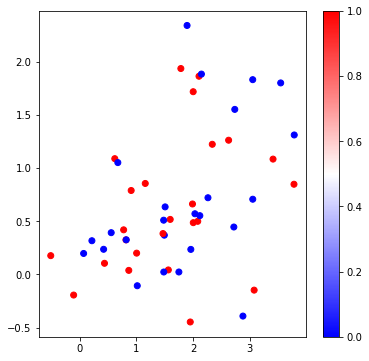

In [182]:
colors = ['navy', 'darkorange','turquoise']
x_test_encoded = predict(get_params(opt_state),data_ss,key)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=labels_np,cmap=plt.get_cmap("bwr"))
plt.colorbar()
plt.show()

In [183]:
@jit
def update(params, x, y, opt_state,key):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y,key)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [184]:
def run_training_loop(data,labels,num_epochs, opt_state,key,verbose=False):
    """ Implements a learning loop over epochs. """
    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        rng,key=random.split(key)
        start_time = time.time()
        params, opt_state, loss = update(params, data, labels, opt_state,rng)
        epoch_time = time.time() - start_time
        if verbose and epoch%500==0: 
            print("Epoch {} | T: {:0.2f} | loss: {:0.3f} ".format(epoch+1, epoch_time,loss))
            x_test_encoded = predict(get_params(opt_state),data_ss,key)
            plt.figure(figsize=(6, 6))
            plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=labels_np,cmap=plt.get_cmap("bwr"))
            plt.colorbar()
            plt.show()
    return loss,params

(1225, 2)
(1225,)
(1225,)
Epoch 1 | T: 0.41 | loss: 1.579 


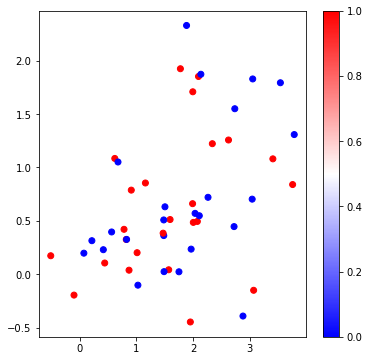

Epoch 501 | T: 0.00 | loss: 0.494 


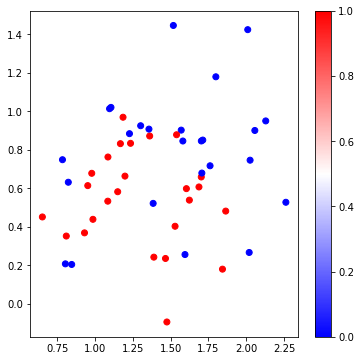

Epoch 1001 | T: 0.00 | loss: 0.249 


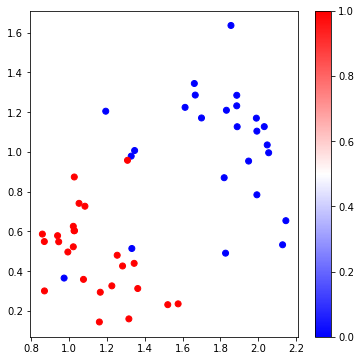

Epoch 1501 | T: 0.00 | loss: 0.048 


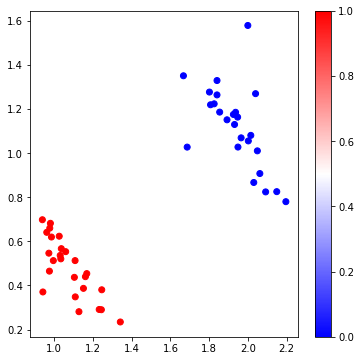

Epoch 2001 | T: 0.00 | loss: 0.016 


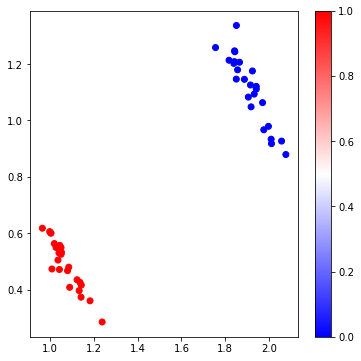

Epoch 2501 | T: 0.00 | loss: 0.008 


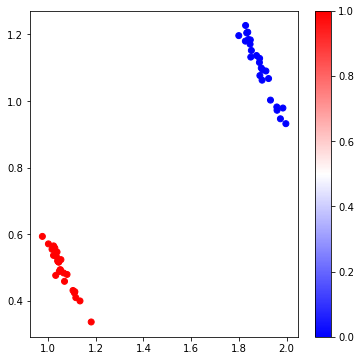

Epoch 3001 | T: 0.00 | loss: 0.004 


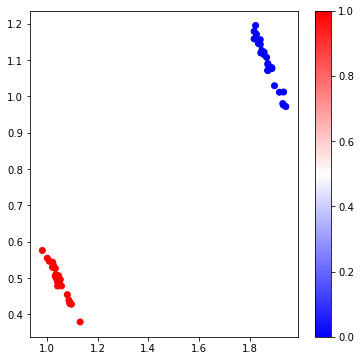

Epoch 3501 | T: 0.00 | loss: 0.002 


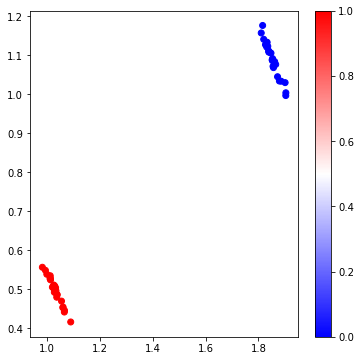

Epoch 4001 | T: 0.00 | loss: 0.001 


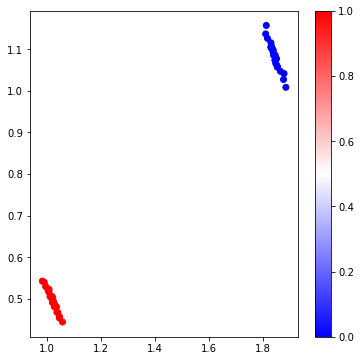

Epoch 4501 | T: 0.00 | loss: 0.001 


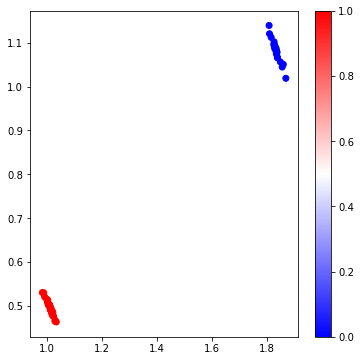

Epoch 5001 | T: 0.00 | loss: 0.000 


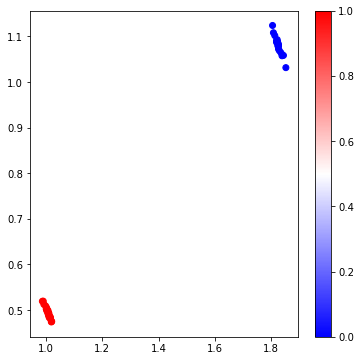

Epoch 5501 | T: 0.00 | loss: 0.000 


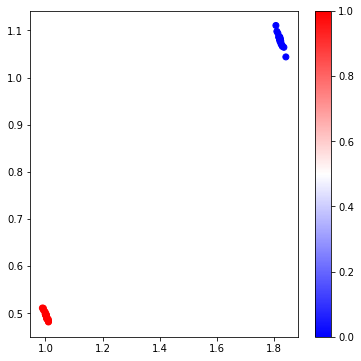

Epoch 6001 | T: 0.00 | loss: 0.000 


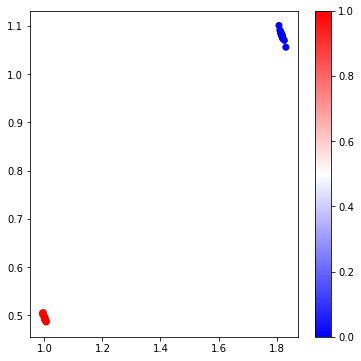

Epoch 6501 | T: 0.00 | loss: 0.000 


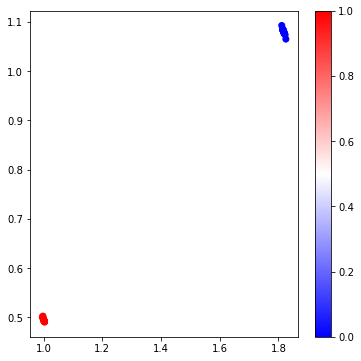

Epoch 7001 | T: 0.00 | loss: 0.000 


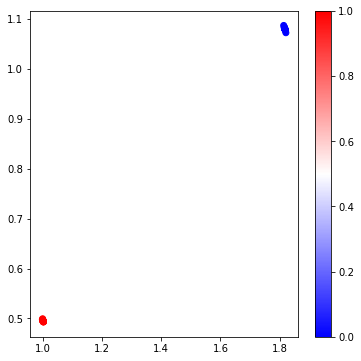

Epoch 7501 | T: 0.00 | loss: 0.000 


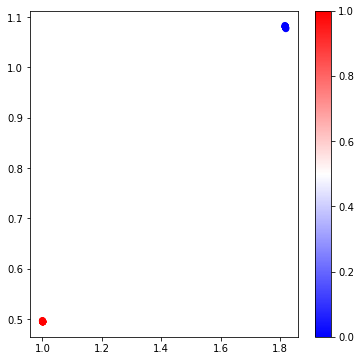

1.5542761e-07


In [185]:
l,params=run_training_loop(data_pairs_np, data_pair_labels_np,8000,opt_state,key,True)
print(l)

In [186]:
def _numpy_delete(x, idx):
    """
    Gets the subarray from `x` where data from index `idx` on the first axis is removed.
    """
    # NB: numpy.delete is not yet available in JAX
    mask = np.arange(x.shape[0] - 1) < idx
    return np.where(mask.reshape((-1,) + (1,) * (x.ndim - 1)), x[:-1], x[1:])
def allButOne(x,y,i):
    global key
    oneX=x[i:i+1] #this return a (1,N) shape vs x[i] gives (N,) shape
    oneY=y[i:i+1]
    allXBut=_numpy_delete(x,i)
    allYBut=_numpy_delete(y,i)
    rng,key=random.split(key)
    idxs=allXBut.shape[0]
    suffleIdx=random.permutation(rng,idxs)
    allXBut=allXBut[suffleIdx]
    allYBut=allYBut[suffleIdx]
    return allXBut,allYBut,oneX,oneY

In [188]:
allXBut,allYBut,oneX,oneY=allButOne(data_ss,labels_np,1)
print(allXBut.shape)
print(allYBut.shape)
print(oneX.shape)
print(oneY.shape)
oneY

(49, 68)
(49,)
(1, 68)
(1,)


array([1.000])

In [ ]:
accT=0
for i in range(data_ss.shape[0]):
    allXBut,allYBut,oneX,oneY=allButOne(data_ss,labels_onehot,i)
    loss,params=run_training_loop(allXBut,allYBut,20000,opt_state)
    p=predict(params,oneX,key)
    acc=accuracy(p,oneY)
    accT+=acc
    print("i=",i,p,oneY,"acc={0:0.3f} accMean={1:0.3f} loss={2:0.3f}".format(acc,accT/(i+1),loss))
print("accMean={0:0.3f}".format(accT/(data_ss.shape[0])))

i= 0 [[0.103 0.897]] [[0.000 1.000]] acc=1.000 accMean=1.000 loss=15.145
i= 1 [[0.006 0.994]] [[0.000 1.000]] acc=1.000 accMean=1.000 loss=19.121
i= 2 [[0.005 0.995]] [[0.000 1.000]] acc=1.000 accMean=1.000 loss=14.487
i= 3 [[0.994 0.006]] [[0.000 1.000]] acc=0.000 accMean=0.750 loss=8.699
i= 4 [[0.270 0.730]] [[0.000 1.000]] acc=1.000 accMean=0.800 loss=12.028
i= 5 [[0.270 0.730]] [[0.000 1.000]] acc=1.000 accMean=0.833 loss=13.367
i= 6 [[0.018 0.982]] [[0.000 1.000]] acc=1.000 accMean=0.857 loss=10.299
i= 7 [[1.000 0.000]] [[0.000 1.000]] acc=0.000 accMean=0.750 loss=12.949
i= 8 [[0.153 0.847]] [[0.000 1.000]] acc=1.000 accMean=0.778 loss=10.225
i= 9 [[0.029 0.971]] [[0.000 1.000]] acc=1.000 accMean=0.800 loss=15.276
i= 10 [[0.065 0.935]] [[1.000 0.000]] acc=0.000 accMean=0.727 loss=11.791
i= 11 [[0.125 0.875]] [[1.000 0.000]] acc=0.000 accMean=0.667 loss=17.323
i= 12 [[0.000 1.000]] [[1.000 0.000]] acc=0.000 accMean=0.615 loss=11.457
i= 13 [[0.565 0.435]] [[1.000 0.000]] acc=1.000 a